# nb-model_xg-model-fr-data

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from collections import OrderedDict
from functools import partial, reduce
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_xg-model-fr-data.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from dask import delayed, compute
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, RECON_DIR, JSON_SFX_LEN, DT_CAL_DAILY_FREQ, pd_to_np, pairwise, df_midx_restack, compose, is_type, df_rows_in_year, list_all_eq, remove_dups_list, NestedDefaultDict, set_loglevel, search_df, chained_filter, get_variants, load_df, dump_df, load_json, gb_transpose, pd_common_index_rows, filter_cols_below, inner_join, outer_join, ser_shift, list_get_dict, window_iter, benchmark
from common_util import pd_rows_key_in, pd_split_ternary_to_binary, np_value_counts, isnt, window_iter, all_eq, np_assert_identical_len_dim, pd_idx_rename, midx_get_level, pd_rows, midx_intersect, pd_get_midx_level, pd_common_idx_rows, midx_split, pd_midx_to_arr, window_iter, np_at_least_nd, np_is_ndim, identity_fn
from model.common import DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TEST_RATIO, VAL_RATIO, EXPECTED_NUM_HOURS, default_dataset
from model.common import PYTORCH_ACT_MAPPING, PYTORCH_OPT_MAPPING, PYTORCH_SCH_MAPPING, PYTORCH_LOSS_MAPPING
from model.xg_util import xgload, get_xg_feature_dfs, get_xg_label_target_dfs
from model.preproc_util import temporal_preproc_3d, stride_preproc_3d
from model.train_util import pd_to_np_tvt, batchify
from model.pl_tcn import TCNModel
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_xg-model-fr-data.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Prune the xg data down to the data of interest to use in further experiments.

## Load Data

In [2]:
assets = ['sp_500', 'russell_2000', 'nasdaq_100', 'dow_jones']
chosen_asset = assets[0]

In [3]:
fd = get_xg_feature_dfs(chosen_asset)
ld, td = get_xg_label_target_dfs(chosen_asset)

INFO:root:pba_hlh_hlogret_hdzn_hdgau(8)_hret_hspread
INFO:root:pba_hoc_hlogret_hdzn_hdgau(8)_hret_hspread
INFO:root:pba_hohlca_hdzn_hdgau(8)
INFO:root:pba_hlh_hlogret_hdmx_hret_hspread
INFO:root:pba_hoc_hlogret_hdmx_hret_hspread
INFO:root:pba_hohlca_hdmx
INFO:root:pba_hlh_hlogret_hdod_hret_hspread
INFO:root:pba_hoc_hlogret_hdod_hret_hspread
INFO:root:pba_hohlca_hdod
INFO:root:pba_hlh_hlogret_hdpt_hret_hspread
INFO:root:pba_hoc_hlogret_hdpt_hret_hspread
INFO:root:pba_hohlca_hdpt
INFO:root:pba_hlh_hlogret_hdmx_hduni(8)_hret_hspread
INFO:root:pba_hoc_hlogret_hdmx_hduni(8)_hret_hspread
INFO:root:pba_hohlca_hdmx_hduni(8)
INFO:root:pba_hlh_hlogret_hdzn_hret_hspread
INFO:root:pba_hoc_hlogret_hdzn_hret_hspread
INFO:root:pba_hohlca_hdzn
INFO:root:pba_hohlca
INFO:root:vol_hlh_hlogret_hdzn_hdgau(8)_hret_hspread
INFO:root:vol_hoc_hlogret_hdzn_hdgau(8)_hret_hspread
INFO:root:vol_hohlca_hdzn_hdgau(8)
INFO:root:vol_hlh_hlogret_hdmx_hret_hspread
INFO:root:vol_hoc_hlogret_hdmx_hret_hspread
INFO:root:vo

INFO:root:pba_hlh_hdxcret1(0.062500%)_dxfbdir1_hdxcret1(0.125000%)_hdxcret1(0.250000%)_hdxcret1(0.500000%)_hdxcret1(1.000000%)_hdxcret1(2.000000%)_hdxcret1(4.000000%)_hdxcret1(8.000000%)
INFO:root:pba_hoc_hdxcret1(0.062500%)_dxfbdir1_hdxcret1(0.125000%)_hdxcret1(0.250000%)_hdxcret1(0.500000%)_hdxcret1(1.000000%)_hdxcret1(2.000000%)_hdxcret1(4.000000%)_hdxcret1(8.000000%)
INFO:root:pba_hlh_hdxcret2(0.5*avg,1)_dxfbdir2_hdxcret2(1*avg,1)_hdxcret2(2*avg,1)
INFO:root:pba_hoc_hdxcret2(0.5*avg,1)_dxfbdir2_hdxcret2(1*avg,1)_hdxcret2(2*avg,1)
INFO:root:pba_hlh_hdxcret2(0.5*mad,1)_dxfbdir2_hdxcret2(1*mad,1)_hdxcret2(2*mad,1)
INFO:root:pba_hoc_hdxcret2(0.5*mad,1)_dxfbdir2_hdxcret2(1*mad,1)_hdxcret2(2*mad,1)
INFO:root:pba_hlh_hdxcret2(0.5*max,1)_dxfbdir2_hdxcret2(1*max,1)_hdxcret2(2*max,1)
INFO:root:pba_hoc_hdxcret2(0.5*max,1)_dxfbdir2_hdxcret2(1*max,1)_hdxcret2(2*max,1)
INFO:root:pba_hlh_hdxcret2(0.5*min,1)_dxfbdir2_hdxcret2(1*min,1)_hdxcret2(2*min,1)
INFO:root:pba_hoc_hdxcret2(0.5*min,1)_dxfbdir

INFO:root:vol_hlh_hdxcret1(0.062500%)_dxfbdir1_hdxcret1(0.125000%)_hdxcret1(0.250000%)_hdxcret1(0.500000%)_hdxcret1(1.000000%)_hdxcret1(2.000000%)_hdxcret1(4.000000%)_hdxcret1(8.000000%)
INFO:root:vol_hoc_hdxcret1(0.062500%)_dxfbdir1_hdxcret1(0.125000%)_hdxcret1(0.250000%)_hdxcret1(0.500000%)_hdxcret1(1.000000%)_hdxcret1(2.000000%)_hdxcret1(4.000000%)_hdxcret1(8.000000%)
INFO:root:vol_hlh_hdxcret2(0.5*avg,1)_dxfbdir2_hdxcret2(1*avg,1)_hdxcret2(2*avg,1)
INFO:root:vol_hoc_hdxcret2(0.5*avg,1)_dxfbdir2_hdxcret2(1*avg,1)_hdxcret2(2*avg,1)
INFO:root:vol_hlh_hdxcret2(0.5*mad,1)_dxfbdir2_hdxcret2(1*mad,1)_hdxcret2(2*mad,1)
INFO:root:vol_hoc_hdxcret2(0.5*mad,1)_dxfbdir2_hdxcret2(1*mad,1)_hdxcret2(2*mad,1)
INFO:root:vol_hlh_hdxcret2(0.5*max,1)_dxfbdir2_hdxcret2(1*max,1)_hdxcret2(2*max,1)
INFO:root:vol_hoc_hdxcret2(0.5*max,1)_dxfbdir2_hdxcret2(1*max,1)_hdxcret2(2*max,1)
INFO:root:vol_hlh_hdxcret2(0.5*min,1)_dxfbdir2_hdxcret2(1*min,1)_hdxcret2(2*min,1)
INFO:root:vol_hoc_hdxcret2(0.5*min,1)_dxfbdir

### Create Final Tensors

In [4]:
get_only = lambda d, i=0: d[list(d.keys())[i]]
subconcat = lambda d: pd.concat(d.values())

## Daily

In [5]:
from xg_util import get_hardcoded_daily_dfs, get_hardcoded_hourly_dfs

In [6]:
d_pba = get_hardcoded_daily_dfs(fd, 'pba')
d_vol = get_hardcoded_daily_dfs(fd, 'vol')
d_buzz = get_hardcoded_daily_dfs(fd, 'buzz')
d_nonbuzz = get_hardcoded_daily_dfs(fd, 'buzz')

In [17]:
h_pba = get_hardcoded_hourly_dfs(fd, 'pba')
h_vol = get_hardcoded_hourly_dfs(fd, 'vol')
h_buzz = get_hardcoded_hourly_dfs(fd, 'buzz')

In [28]:
def df_filter_by_keywords(fdf, keywords):
	cols = [col for col in fdf.index.levels[1] if (any(keyword in col for keyword in keywords))]
	return pd_rows_key_in(fdf, 'id1', cols)

def get_hardcoded_daily_dfs(fd, src):
	"""
	Return hardcoded daily freq feature dfs to use in experiments.
	"""
	feature_dfs = []

	if (src in ('pba', 'vol')):
		feature_dfs.append(fd['d'][src]['dlogret']['{src}_dlh_dlogret'.format(src=src)])

	if (src in ('pba', 'vol', 'buzz')):
		for axe in ('dffd', 'dwrmx', 'dwrod', 'dwrpt', 'dwrzn'):
			for fdf in fd['d'][src][axe].values():
				#feature_dfs.append(df_filter_by_keywords(fdf, ('avgPrice', 'high', 'low')))
				#feature_dfs.append(df_filter_by_keywords(fdf, ('avgPrice', 'high', 'low', 'close')))
				feature_dfs.append(df_filter_by_keywords(fdf, ('high',)))
                
	if (src in ('nonbuzz',)):
		for axe in ('dffd', 'dwrxmx'):
			for fdf in fd['d'][src][axe].values():
				feature_dfs.append(fdf)

	#return pd.concat(feature_dfs).sort_index(axis=0)
	return pd.concat(feature_dfs)

def get_hardcoded_hourly_dfs(fd, src):
	"""
	Return hardcoded hourly freq feature dfs to use in experiments.
	"""
	feature_dfs = []

	if (src in ('pba', 'vol', 'buzz')):
		for axe in ('hdmx', 'hdod', 'hdpt', 'hdzn', 'hdgau', 'hduni'):
			for fdf in fd['h'][src][axe].values():
				feature_dfs.append(df_filter_by_keywords(fdf, ('avgPrice', 'high', 'low', 'close')))

	return pd.concat(feature_dfs)

In [29]:
get_hardcoded_daily_dfs(fd, 'pba').unstack()

-1  \
id1        pba_high_pba_dohlca_dffd(0.200000,0.010000)   
id0                                                      
1996-01-02                                         NaN   
1996-01-03                                         NaN   
1996-01-04                                         NaN   
1996-01-05                                         NaN   
1996-01-08                                         NaN   
...                                                ...   
2018-01-02                                 1452.496934   
2018-01-03                                 1469.747350   
2018-01-04                                 1480.515593   
2018-01-05                                 1489.937928   
2018-01-08                                 1489.864939   

                                                        \
id1        pba_high_pba_dohlca_dffd(0.400000,0.010000)   
id0                                                      
1996-01-02                                         NaN   
1996-01-03                                         NaN   
1996-01-04                                         NaN   
1996-01-05                                         NaN   
1996-01-08                                         NaN   
...                                                ...   
2018-01-02                                  716.521337   
2018-01-03                                  732.813778   
2018-01-04                                  739.651928   
2018-01-05                                  745.247739   
2018-01-08                                  741.395455   

                                                        \
id1        pba_high_pba_dohlca_dffd(0.600000,0.010000)   
id0                                                      
1996-01-02                                         NaN   
1996-01-03                                         NaN   
1996-01-04                                         NaN   
1996-01-05                                         NaN   
1996-01-08                                         NaN   
...                                                ...   
2018-01-02                                  348.448351   
2018-01-03                                  364.116769   
2018-01-04                                  367.233580   
2018-01-05                                  369.877378   
2018-01-08                                  363.343183   

                                                        \
id1        pba_high_pba_dohlca_dffd(0.800000,0.010000)   
id0                                                      
1996-01-02                                         NaN   
1996-01-03                                         NaN   
1996-01-04                                         NaN   
1996-01-05                                         NaN   
1996-01-08                                         NaN   
...                                                ...   
2018-01-02                                  163.776714   
2018-01-03                                  178.797633   
2018-01-04                                  178.421095   
2018-01-05                                  178.944806   
2018-01-08                                  170.775256   

                                                                        \
id1        pba_high_pba_dohlca_dwrmx(-1) pba_high_pba_dohlca_dwrmx(20)   
id0                                                                      
1996-01-02                           NaN                           NaN   
1996-01-03                      1.000000                      1.000000   
1996-01-04                      1.000000                      1.000000   
1996-01-05                     -1.000000                     -1.000000   
1996-01-08                     -0.776141                     -0.776141   
...                                  ...                           ...   
2018-01-02                     -0.464479                      1.000000   
2018-01-03                     -0.459751                    

In [8]:
chosen_f = d_buzz
chosen_l = pd_split_ternary_to_binary(ld['hoc']['pba']['ddir'].replace(to_replace=-1, value=0))
chosen_t = pd_split_ternary_to_binary(td['hoc']['pba']['dret'])

In [9]:
year_interval = ('2009', '2018')
common_idx = midx_intersect(pd_get_midx_level(chosen_f), pd_get_midx_level(chosen_l), pd_get_midx_level(chosen_t))
common_idx = common_idx[(common_idx > year_interval[0]) & (common_idx < year_interval[1])]
feature_df, label_df, target_df = map(compose(partial(pd_rows, idx=common_idx), df_midx_restack), [chosen_f, chosen_l, chosen_t])
assert(all(feature_df.index.levels[0]==label_df.index.levels[0]))
assert(all(feature_df.index.levels[0]==target_df.index.levels[0]))

KeyboardInterrupt: 

In [27]:
feature_df

-1
id0        id1                                                             
2009-01-02 etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlc...  14044.635671
           etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlc...  -6294.918321
           etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlc... -16564.762295
           etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlc... -22771.447294
           etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlc...     -0.674291
...                                                                     ...
2017-12-29 mkt3_stockIndexBuzz_S_low_trmi3_mkt3_social_sto...      0.962009
           mkt3_stockIndexBuzz_S_low_trmi3_mkt3_social_sto...      0.010889
           mkt3_stockIndexBuzz_S_low_trmi3_mkt3_social_sto...     -0.150838
           mkt3_stockIndexBuzz_S_low_trmi3_mkt3_social_sto...     -0.659457
           mkt3_stockIndexBuzz_S_low_trmi3_mkt3_social_sto...      0.769260

[1449600 rows x 1 columns]

In [5]:
gt = 0
total = 0
for k, d in fd['d']['pba'].items():
    #print(k)
    keys = d.keys()
    if (k in ('ddir1', 'dxfbdir1', 'dret1', 'dxfbcret1', 'dxfbval1')):
        keys = tuple(filter(lambda k: '0.062500%' in k, keys))
    total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(list(fd['d']['pba'].keys()))), total)
gt += total
total = 0
for k, d in fd['d']['vol'].items():
    #print(k)
    keys = d.keys()
    if (k in ('ddir1', 'dxfbdir1', 'dret1', 'dxfbcret1', 'dxfbval1')):
        keys = tuple(filter(lambda k: '0.062500%' in k, keys))
    total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(list(fd['d']['vol'].keys()))), total)
gt += total
total = 0
for k, d in fd['d']['buzz'].items():
    #print(k)
    keys = d.keys()
    if (k in ('ddir1', 'dxfbdir1', 'dret1', 'dxfbcret1', 'dxfbval1')):
        keys = tuple(filter(lambda k: '0.062500%' in k, keys))
    total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(list(fd['d']['buzz'].keys()))), total)
gt += total
total = 0
for k, d in fd['d']['nonbuzz'].items():
    #print(k)
    keys = d.keys()
    if (k in ('ddir1', 'dxfbdir1', 'dret1', 'dxfbcret1', 'dxfbval1')):
        keys = tuple(filter(lambda k: '0.062500%' in k, keys))
    total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(list(fd['d']['nonbuzz'].keys()))), total)
gt += total
print('gt:', gt)

20 346
20 346
7 880
4 1298
gt: 2870


In [177]:
gt = 0

# pba
total = 0
top5pct = ['dlogret', 'dffd', 'dwrmx', 'dwrod', 'dwrpt', 'dwrzn']
for k, d in fd['d']['pba'].items():
    #print(k)
    keys = d.keys()
    if (k in top5pct):
        total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(top5pct)), total)
gt += total

# vol
total = 0
top5pct = ['dlogret', 'dffd', 'dwrmx', 'dwrod', 'dwrpt', 'dwrzn'] # for vol, dohlca works better than dlogret
for k, d in fd['d']['vol'].items():
    #print(k)
    keys = d.keys()
    if (k in top5pct):
        total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(top5pct)), total)
gt += total

# buzz
total = 0
top5pct = ['ddiff', 'dffd', 'dwrmx', 'dwrod', 'dwrpt', 'dwrzn']
for k, d in fd['d']['buzz'].items():
    #print(k)
    keys = d.keys()
    if (k in top5pct):
        total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(top5pct)), total)
gt += total

# nonbuzz
total = 0
top5pct = ['dffd']
for k, d in fd['d']['nonbuzz'].items():
    #print(k)
    keys = d.keys()
    if (k in top5pct):
        total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(top5pct)), total)
gt += total

print('gt:', gt)

6 102
6 102
6 840
1 472
gt: 1516


In [178]:
total = 0
top5pct = ['dc']
for k, d in fd['d']['nonbuzz'].items():
    #print(k)
    keys = d.keys()
    if (k in top5pct):
        total += len(pd.concat((df for key, df in d.items() if (key in keys))).unstack().columns)
print(str(len(top5pct)), total)

1 118


In [274]:
_df = get_only(fd['d']['buzz']['dwrod'])
cols = [col for col in _df.index.levels[1] if ('avgPrice' in col or 'high' in col or 'low' in col)]
pd_rows_key_in(_df, 'id1', cols).unstack()

-1  \
id1        etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlca_dwrod(-1)   
id0                                                                     
1998-01-01                                           1.000000           
1998-01-02                                           0.500000           
1998-01-03                                           0.666667           
1998-01-04                                           0.500000           
1998-01-05                                           1.000000           
...                                                       ...           
2018-01-05                                           0.794391           
2018-01-06                                           0.555328           
2018-01-07                                           0.443791           
2018-01-08                                           0.637358           
2018-01-09                                           0.850287           

                                                                       \
id1        etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlca_dwrod(20)   
id0                                                                     
1998-01-01                                           1.000000           
1998-01-02                                           0.500000           
1998-01-03                                           0.666667           
1998-01-04                                           0.500000           
1998-01-05                                           1.000000           
...                                                       ...           
2018-01-05                                           0.900000           
2018-01-06                                           0.450000           
2018-01-07                                           0.250000           
2018-01-08                                           0.650000           
2018-01-09                                           1.000000           

                                                                        \
id1        etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlca_dwrod(240)   
id0                                                                      
1998-01-01                                           1.000000            
1998-01-02                                           0.500000            
1998-01-03                                           0.666667            
1998-01-04                                           0.500000            
1998-01-05                                           1.000000            
...                                                       ...            
2018-01-05                                           0.600000            
2018-01-06                                           0.229167            
2018-01-07                                           0.062500            
2018-01-08                                           0.350000            
2018-01-09                                           0.770833            

                                                                      \
id1        etf3_buzz_N_avgPrice_trmi3_etf3_news_buzz_dohlca_dwrod(5)   
id0                                                                    
1998-01-01                                           1.000000          
1998-01-02                                           0.500000          
1998-01-03                                           0.666667          
1998-01-04                                           0.500000          
1998-01-05                                           1.000000          
...                                                       ...          
2018-01-05                                           0.800000          
2018-01-06                                           0.400000          
2018-01-07                                           0.200000          
2018-01-08                                           0.600000          
2018-01-09                                      

In [234]:
_df = get_only(fd['d']['pba']['dffd'])
cols = [col for col in _df.index.levels[1] if ('avgPrice' in col or 'high' in col or 'low' in col)]
pd_rows_key_in(_df, 'id1', cols).unstack()

-1  \
id1        pba_avgPrice_pba_dohlca_dffd(0.800000,0.010000)   
id0                                                          
1996-01-09                                       32.678457   
1996-01-10                                       24.786501   
1996-01-11                                       31.608528   
1996-01-12                                       35.020548   
1996-01-15                                       34.609623   
...                                                    ...   
2018-01-02                                      165.878414   
2018-01-03                                      178.112888   
2018-01-04                                      179.593426   
2018-01-05                                      174.715244   
2018-01-08                                      174.107764   

                                                        \
id1        pba_high_pba_dohlca_dffd(0.800000,0.010000)   
id0                                                      
1996-01-09                                   37.021105   
1996-01-10                                   26.875488   
1996-01-11                                   27.921505   
1996-01-12                                   36.220531   
1996-01-15                                   34.007427   
...                                                ...   
2018-01-02                                  163.776714   
2018-01-03                                  178.797633   
2018-01-04                                  178.421095   
2018-01-05                                  178.944806   
2018-01-08                                  170.775256   

                                                       \
id1        pba_low_pba_dohlca_dffd(0.800000,0.010000)   
id0                                                     
1996-01-09                                  28.598677   
1996-01-10                                  24.033740   
1996-01-11                                  33.636323   
1996-01-12                                  34.438063   
1996-01-15                                  35.936881   
...                                               ...   
2018-01-02                                 165.833128   
2018-01-03                                 174.833763   
2018-01-04                                 183.319094   
2018-01-05                                 173.733524   
2018-01-08                                 174.084681   

                                                            \
id1        pba_avgPrice_pba_dohlca_dffd(0.600000,0.010000)   
id0                                                          
1996-01-09                                             NaN   
1996-01-10                                             NaN   
1996-01-11                                             NaN   
1996-01-12                                       74.465121   
1996-01-15                                       74.620697   
...                                                    ...   
2018-01-02                                      349.396326   
2018-01-03                                      363.096432   
2018-01-04                                      367.889679   
2018-01-05                                      365.454162   
2018-01-08                                      365.602944   

                                                        \
id1        pba_high_pba_dohlca_dffd(0.600000,0.010000)   
id0                                                      
1996-01-09                                         NaN   
1996-01-10                                         NaN   
1996-01-11                                         NaN   
1996-01-12                                   75.536229   
1996-01-15                                   74.295466   
...                                                ...   
2018-01-02                                  348.448351   
2018-01-03                                  364.116769   
2018-01-04                                  367.233580   
2018-01-05

In [235]:
_df = get_only(fd['d']['pba']['dwrmx'])
cols = [col for col in _df.index.levels[1] if ('avgPrice' in col or 'high' in col or 'low' in col)]
pd_rows_key_in(_df, 'id1', cols).unstack()

-1  \
id1        pba_avgPrice_pba_dohlca_dwrmx(-1)   
id0                                            
1996-01-03                          1.000000   
1996-01-04                         -0.155174   
1996-01-05                         -1.000000   
1996-01-08                         -0.266559   
1996-01-09                         -1.000000   
...                                      ...   
2018-01-02                          0.998464   
2018-01-03                          1.000000   
2018-01-04                          1.000000   
2018-01-05                          1.000000   
2018-01-08                          1.000000   

                                              \
id1        pba_avgPrice_pba_dohlca_dwrmx(20)   
id0                                            
1996-01-03                          1.000000   
1996-01-04                         -0.155174   
1996-01-05                         -1.000000   
1996-01-08                         -0.266559   
1996-01-09                         -1.000000   
...                                      ...   
2018-01-02                          0.948409   
2018-01-03                          1.000000   
2018-01-04                          1.000000   
2018-01-05                          1.000000   
2018-01-08                          1.000000   

                                               \
id1        pba_avgPrice_pba_dohlca_dwrmx(240)   
id0                                             
1996-01-03                           1.000000   
1996-01-04                          -0.155174   
1996-01-05                          -1.000000   
1996-01-08                          -0.266559   
1996-01-09                          -1.000000   
...                                       ...   
2018-01-02                           0.992502   
2018-01-03                           1.000000   
2018-01-04                           1.000000   
2018-01-05                           1.000000   
2018-01-08                           1.000000   

                                                                           \
id1        pba_avgPrice_pba_dohlca_dwrmx(5) pba_high_pba_dohlca_dwrmx(-1)   
id0                                                                         
1996-01-03                         1.000000                      1.000000   
1996-01-04                        -0.155174                      1.000000   
1996-01-05                        -1.000000                     -1.000000   
1996-01-08                        -0.266559                     -0.776141   
1996-01-09                        -1.000000                     -0.572901   
...                                     ...                           ...   
2018-01-02                         1.000000                     -0.464479   
2018-01-03                         1.000000                     -0.459751   
2018-01-04                         1.000000                     -0.455934   
2018-01-05                         1.000000                     -0.452311   
2018-01-08                         1.000000                     -0.451017   

                                                                         \
id1        pba_high_pba_dohlca_dwrmx(20) pba_high_pba_dohlca_dwrmx(240)   
id0                                                                       
1996-01-03                      1.000000                       1.000000   
1996-01-04                      1.000000                       1.000000   
1996-01-05                     -1.000000                      -1.000000   
1996-01-08                     -0.776141                      -0.776141   
1996-01-09                     -0.572901                      -0.572901   
...                                  ...                            ...   
2018-01-02                      1.000000                       1.000000   
2018-01-03                      1.000000                       1.000000   
2018-01-04                      1.000000                       1.000000   
2018-01-05                    

In [236]:
_df = get_only(fd['d']['pba']['dwrzn'])
cols = [col for col in _df.index.levels[1] if ('avgPrice' in col or 'high' in col or 'low' in col)]
pd_rows_key_in(_df, 'id1', cols).unstack()

-1  \
id1        pba_avgPrice_pba_dohlca_dwrzn(-1)   
id0                                            
1996-01-03                          0.707107   
1996-01-04                         -0.103037   
1996-01-05                         -1.224349   
1996-01-08                         -0.321575   
1996-01-09                         -1.334913   
...                                      ...   
2018-01-02                          3.041606   
2018-01-03                          3.079629   
2018-01-04                          3.114082   
2018-01-05                          3.133671   
2018-01-08                          3.151840   

                                              \
id1        pba_avgPrice_pba_dohlca_dwrzn(20)   
id0                                            
1996-01-03                          0.707107   
1996-01-04                         -0.103037   
1996-01-05                         -1.224349   
1996-01-08                         -0.321575   
1996-01-09                         -1.334913   
...                                      ...   
2018-01-02                          1.109677   
2018-01-03                          1.754741   
2018-01-04                          2.164491   
2018-01-05                          2.282760   
2018-01-08                          2.310425   

                                               \
id1        pba_avgPrice_pba_dohlca_dwrzn(240)   
id0                                             
1996-01-03                           0.707107   
1996-01-04                          -0.103037   
1996-01-05                          -1.224349   
1996-01-08                          -0.321575   
1996-01-09                          -1.334913   
...                                       ...   
2018-01-02                           2.199138   
2018-01-03                           2.340760   
2018-01-04                           2.464121   
2018-01-05                           2.521852   
2018-01-08                           2.569007   

                                                                           \
id1        pba_avgPrice_pba_dohlca_dwrzn(5) pba_high_pba_dohlca_dwrzn(-1)   
id0                                                                         
1996-01-03                         0.707107                      0.707107   
1996-01-04                        -0.103037                      0.870624   
1996-01-05                        -1.224349                     -1.281380   
1996-01-08                        -0.321575                     -0.838832   
1996-01-09                        -1.179797                     -0.542766   
...                                     ...                           ...   
2018-01-02                         1.639730                      2.962739   
2018-01-03                         1.707599                      3.001176   
2018-01-04                         1.481283                      3.031580   
2018-01-05                         1.206841                      3.060195   
2018-01-08                         1.103885                      3.068537   

                                                                         \
id1        pba_high_pba_dohlca_dwrzn(20) pba_high_pba_dohlca_dwrzn(240)   
id0                                                                       
1996-01-03                      0.707107                       0.707107   
1996-01-04                      0.870624                       0.870624   
1996-01-05                     -1.281380                      -1.281380   
1996-01-08                     -0.838832                      -0.838832   
1996-01-09                     -0.542766                      -0.542766   
...                                  ...                            ...   
2018-01-02                      1.108764                       2.203964   
2018-01-03                      1.778625                       2.350713   
2018-01-04                      2.106275                       2.459906   
2018-01-05                    

In [239]:
_df = get_only(fd['d']['pba']['dwrod'])
cols = [col for col in _df.index.levels[1] if ('avgPrice' in col or 'high' in col or 'low' in col)]
dwrod = pd_rows_key_in(_df, 'id1', cols).unstack()

In [240]:
_df = get_only(fd['d']['pba']['dwrpt'])
cols = [col for col in _df.index.levels[1] if ('avgPrice' in col or 'high' in col or 'low' in col)]
dwrpt = pd_rows_key_in(_df, 'id1', cols).unstack()

In [269]:
dwrod.corr().groupby((-1,  'pba_avgPrice_pba_dohlca_dwrod(-1)')).mean()

-1  \
id1                                     pba_avgPrice_pba_dohlca_dwrod(20)   
(-1, pba_avgPrice_pba_dohlca_dwrod(-1))                                     
0.106767                                                         0.647174   
0.108092                                                         0.679117   
0.111527                                                         0.677977   
0.186850                                                         0.978431   
0.198161                                                         1.000000   
0.208221                                                         0.974617   
0.563892                                                         0.467724   
0.571675                                                         0.462478   
0.576658                                                         0.445382   
0.998281                                                         0.202379   
0.998707                                                         0.188558   
1.000000                                                         0.198161   

                                                                            \
id1                                     pba_avgPrice_pba_dohlca_dwrod(240)   
(-1, pba_avgPrice_pba_dohlca_dwrod(-1))                                      
0.106767                                                          0.235041   
0.108092                                                          0.245180   
0.111527                                                          0.254738   
0.186850                                                          0.447293   
0.198161                                                          0.462478   
0.208221                                                          0.477166   
0.563892                                                          0.996738   
0.571675                                                          1.000000   
0.576658                                                          0.997735   
0.998281                                                          0.575411   
0.998707                                                          0.564363   
1.000000                                                          0.571675   

                                                                          \
id1                                     pba_avgPrice_pba_dohlca_dwrod(5)   
(-1, pba_avgPrice_pba_dohlca_dwrod(-1))                                    
0.106767                                                        0.913141   
0.108092                                                        1.000000   
0.111527                                                        0.903637   
0.186850                                                        0.646155   
0.198161                                                        0.679117   
0.208221                                                        0.615113   
0.563892                                                        0.243479   
0.571675                                                        0.245180   
0.576658                                                        0.224776   
0.998281                                                        0.109114   
0.998707                                                        0.097843   
1.000000                                                        0.108092   

                                                                       \
id1                                     pba_high_pba_dohlca_dwrod(-1)   
(-1, pba_avgPrice_pba_dohlca_dwrod(-1))                                 
0.106767                                                     0.096132   
0.108092                                                     0.097843   
0.111527                                                     0.106067   
0.186850                                                     0.176818   
0.198161                                                     0.188558   
0.208221           

In [247]:
dwrod

-1  \
id1        pba_avgPrice_pba_dohlca_dwrod(-1)   
id0                                            
1996-01-02                          1.000000   
1996-01-03                          1.000000   
1996-01-04                          0.666667   
1996-01-05                          0.250000   
1996-01-08                          0.400000   
...                                      ...   
2018-01-02                          0.999818   
2018-01-03                          1.000000   
2018-01-04                          1.000000   
2018-01-05                          1.000000   
2018-01-08                          1.000000   

                                              \
id1        pba_avgPrice_pba_dohlca_dwrod(20)   
id0                                            
1996-01-02                          1.000000   
1996-01-03                          1.000000   
1996-01-04                          0.666667   
1996-01-05                          0.250000   
1996-01-08                          0.400000   
...                                      ...   
2018-01-02                          0.950000   
2018-01-03                          1.000000   
2018-01-04                          1.000000   
2018-01-05                          1.000000   
2018-01-08                          1.000000   

                                               \
id1        pba_avgPrice_pba_dohlca_dwrod(240)   
id0                                             
1996-01-02                           1.000000   
1996-01-03                           1.000000   
1996-01-04                           0.666667   
1996-01-05                           0.250000   
1996-01-08                           0.400000   
...                                       ...   
2018-01-02                           0.995833   
2018-01-03                           1.000000   
2018-01-04                           1.000000   
2018-01-05                           1.000000   
2018-01-08                           1.000000   

                                                                           \
id1        pba_avgPrice_pba_dohlca_dwrod(5) pba_high_pba_dohlca_dwrod(-1)   
id0                                                                         
1996-01-02                         1.000000                      1.000000   
1996-01-03                         1.000000                      1.000000   
1996-01-04                         0.666667                      1.000000   
1996-01-05                         0.250000                      0.250000   
1996-01-08                         0.400000                      0.400000   
...                                     ...                           ...   
2018-01-02                         1.000000                      0.999818   
2018-01-03                         1.000000                      0.999818   
2018-01-04                         1.000000                      0.999818   
2018-01-05                         1.000000                      0.999819   
2018-01-08                         1.000000                      0.999819   

                                                                         \
id1        pba_high_pba_dohlca_dwrod(20) pba_high_pba_dohlca_dwrod(240)   
id0                                                                       
1996-01-02                          1.00                           1.00   
1996-01-03                          1.00                           1.00   
1996-01-04                          1.00                           1.00   
1996-01-05                          0.25                           0.25   
1996-01-08                          0.40                           0.40   
...                                  ...                            ...   
2018-01-02                          1.00                           1.00   
2018-01-03                          1.00                           1.00   
2018-01-04                          1.00                           1.00   
2018-01-05                    

In [148]:
gt = 0
total = 0
for k, d in fd['h']['pba'].items():
    #print(k)
    total += len(subconcat(d).index.levels[1])
print(str(len(list(fd['h']['pba'].keys()))), total)
gt += total
total = 0
for k, d in fd['h']['vol'].items():
    #print(k)
    total += len(subconcat(d).index.levels[1])
print(str(len(list(fd['h']['vol'].keys()))), total)
gt += total
total = 0
for k, d in fd['h']['buzz'].items():
    #print(k)
    total += len(subconcat(d).index.levels[1])
print(str(len(list(fd['h']['buzz'].keys()))), total)
gt += total
total = 0
print('gt:', gt)

7 71
7 71
7 104
gt: 246


In [143]:
2870+246

3116

In [48]:
ex = subconcat(fd['d']['pba']['dlogret'])
year_interval = ('2009', '2018')
ex = ex[(ex.index > year_interval[0]) & (ex.index < year_interval[1])]

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'numpy.ndarray'

In [68]:
pd.concat((get_only(fd['d']['pba']['dwrmx']),
          get_only(fd['d']['pba']['dwrzn']),
          get_only(fd['d']['pba']['dwrod']),
          get_only(fd['d']['pba']['dwrpt']))).unstack().corr()

-1  \
id1                                   pba_avgPrice_pba_dohlca_dwrmx(-1)   
   id1                                                                    
-1 pba_avgPrice_pba_dohlca_dwrmx(-1)                           1.000000   
   pba_avgPrice_pba_dohlca_dwrmx(20)                           0.222375   
   pba_avgPrice_pba_dohlca_dwrmx(240)                          0.597670   
   pba_avgPrice_pba_dohlca_dwrmx(5)                            0.122761   
   pba_avgPrice_pba_dohlca_dwrod(-1)                           0.981293   
   pba_avgPrice_pba_dohlca_dwrod(20)                           0.199343   
   pba_avgPrice_pba_dohlca_dwrod(240)                          0.532983   
   pba_avgPrice_pba_dohlca_dwrod(5)                            0.113856   
   pba_avgPrice_pba_dohlca_dwrpt(-1)                           1.000000   
   pba_avgPrice_pba_dohlca_dwrpt(20)                           0.222375   
   pba_avgPrice_pba_dohlca_dwrpt(240)                          0.597670   
   pba_avgPrice_pba_dohlca_dwrpt(5)                            0.122761   
   pba_avgPrice_pba_dohlca_dwrzn(-1)                           0.961101   
   pba_avgPrice_pba_dohlca_dwrzn(20)                           0.200636   
   pba_avgPrice_pba_dohlca_dwrzn(240)                          0.542709   
   pba_avgPrice_pba_dohlca_dwrzn(5)                            0.116467   
   pba_close_pba_dohlca_dwrmx(-1)                              0.981775   
   pba_close_pba_dohlca_dwrmx(20)                              0.220920   
   pba_close_pba_dohlca_dwrmx(240)                             0.575785   
   pba_close_pba_dohlca_dwrmx(5)                               0.107697   
   pba_close_pba_dohlca_dwrod(-1)                              0.979842   
   pba_close_pba_dohlca_dwrod(20)                              0.198504   
   pba_close_pba_dohlca_dwrod(240)                             0.531235   
   pba_close_pba_dohlca_dwrod(5)                               0.105913   
   pba_close_pba_dohlca_dwrpt(-1)                              0.981775   
   pba_close_pba_dohlca_dwrpt(20)                              0.220920   
   pba_close_pba_dohlca_dwrpt(240)                             0.575785   
   pba_close_pba_dohlca_dwrpt(5)                               0.107697   
   pba_close_pba_dohlca_dwrzn(-1)                              0.959206   
   pba_close_pba_dohlca_dwrzn(20)                              0.196182   
   pba_close_pba_dohlca_dwrzn(240)                             0.547725   
   pba_close_pba_dohlca_dwrzn(5)                               0.104661   
   pba_high_pba_dohlca_dwrmx(-1)                               0.324887   
   pba_high_pba_dohlca_dwrmx(20)                               0.217508   
   pba_high_pba_dohlca_dwrmx(240)                              0.485621   
   pba_high_pba_dohlca_dwrmx(5)                                0.119356   
   pba_high_pba_dohlca_dwrod(-1)                               0.980876   
   pba_high_pba_dohlca_dwrod(20)                               0.208206   
   pba_high_pba_dohlca_dwrod(240)                              0.537214   
   pba_high_pba_dohlca_dwrod(5)                                0.116609   
   pba_high_pba_dohlca_dwrpt(-1)                               0.324887   
   pba_high_pba_dohlca_dwrpt(20)                               0.217508   
   pba_high_pba_dohlca_dwrpt(240)                              0.485621   
   pba_high_pba_dohlca_dwrpt(5)                                0.119356   
   pba_high_pba_dohlca_dwrzn(-1)                               0.868048   
   pba_high_pba_dohlca_dwrzn(20)                               0.205826   
   pba_high_pba_dohlca_dwrzn(240)                              0.516138   
   pba_high_pba_dohlca_dwrzn(5)                                0.118848   
   pba_low_pba_dohlca_dwrmx(-1)                                0.981648   
   pba_low_pba_dohlca_dwrmx(20)                                0.205484   
   pba_low_pba_dohlca_dwrmx(240)                               0.576417   
   pba_low_pba_dohl

In [141]:
get_only(fd['h']['pba']['hdmx']).index.levels[1]

Index(['pba_lh_pba_hlh_hlogret_hdmx', 'pba_lh_pba_hlh_hret_hdmx',
       'pba_lh_pba_hlh_hspread_hdmx'],
      dtype='object', name='id1')

In [4]:
d_all_common = ['dwrmx', 'dwrod', 'dwrpt', 'dwrzn', 'dffd']
d_extra = ['dlogret', 'dohlca', 'ddiff', 'dc', 'dwrxmx']

In [5]:
h_all_common = ['hdmx', 'hdod', 'hdpt', 'hdzn']
h_extra = ['hdgau', 'hduni', 'hohlca']

Test axefiles per asset and source (4 * 4 * 5 + 4 * 3 * 4 = ~128 tests) , what model to use?
* TCN
* XGBOOST
* RF

OR I just make a best guess on the best features. I record the tensor dimensions (allow easy modification) and get going on the meat of this stuff. I can start with only h/d pba, play with that until it's working well then iteratively add other sources.

I start with one asset, move to others after the first asset's model works.

I know roughly what features to use. I need to now determine the model design.

In [6]:
h_all_common, d_all_common

(['hdmx', 'hdod', 'hdpt', 'hdzn'],
 ['dwrmx', 'dwrod', 'dwrpt', 'dwrzn', 'dffd'])

## Select Data

### Choose Features and Join

In [7]:
for k0, v0 in fd.items():
    print(k0)
    for k1,v1 in fd[k0].items():
        print('\t' +k1)
        for k2, v2 in fd[k0][k1].items():
            print('\t\t' +k2)
            for k3, v3 in fd[k0][k1][k2].items():
                print('\t\t\t' +k3)

h
	pba
		hdgau
			pba_hlh_hlogret_hdzn_hdgau(8)_hret_hspread
			pba_hoc_hlogret_hdzn_hdgau(8)_hret_hspread
			pba_hohlca_hdzn_hdgau(8)
		hdmx
			pba_hlh_hlogret_hdmx_hret_hspread
			pba_hoc_hlogret_hdmx_hret_hspread
			pba_hohlca_hdmx
		hdod
			pba_hlh_hlogret_hdod_hret_hspread
			pba_hoc_hlogret_hdod_hret_hspread
			pba_hohlca_hdod
		hdpt
			pba_hlh_hlogret_hdpt_hret_hspread
			pba_hoc_hlogret_hdpt_hret_hspread
			pba_hohlca_hdpt
		hduni
			pba_hlh_hlogret_hdmx_hduni(8)_hret_hspread
			pba_hoc_hlogret_hdmx_hduni(8)_hret_hspread
			pba_hohlca_hdmx_hduni(8)
		hdzn
			pba_hlh_hlogret_hdzn_hret_hspread
			pba_hoc_hlogret_hdzn_hret_hspread
			pba_hohlca_hdzn
		hohlca
			pba_hohlca
	vol
		hdgau
			vol_hlh_hlogret_hdzn_hdgau(8)_hret_hspread
			vol_hoc_hlogret_hdzn_hdgau(8)_hret_hspread
			vol_hohlca_hdzn_hdgau(8)
		hdmx
			vol_hlh_hlogret_hdmx_hret_hspread
			vol_hoc_hlogret_hdmx_hret_hspread
			vol_hohlca_hdmx
		hdod
			vol_hlh_hlogret_hdod_hret_hspread
			vol_hoc_hlogret_hdod_hret_hspread


In [8]:
#chosen_f = fd['h']['pba']['hdgau']['pba_hlh_hlogret_hdzn_hdgau(8)_hret_hspread']
#chosen_f = fd['h']['pba']['hdzn']['pba_hohlca_hdzn']

In [9]:
#for ser_name in chosen_f.index.unique(level='id1'):
#    print('\t' +ser_name)
#    ser_subset_df = chosen_f.xs(ser_name, level=1, drop_level=False)
#    ser_subset_df.index = ser_subset_df.index.remove_unused_levels()
#    display(pd_to_np(ser_subset_df))
#    ser_subset_df.isnan()
#    np.isnan(ser_subset_df.values).any()

In [10]:
pba_d_all_common = {}
for a in d_all_common[:4]:
    pba_d_all_common[a] = fd['d']['pba'][a]['pba_dohlca_{a}(-1)_{a}(20)_{a}(240)_{a}(5)'.format(a=a)]

pba_d_all_common[d_all_common[4]] = fd['d']['pba'][d_all_common[4]]['pba_dohlca_{a}(0.200000,0.010000)_{a}(0.400000,0.010000)_{a}(0.600000,0.010000)_{a}(0.800000,0.010000)'.format(a=d_all_common[4])]

In [11]:
vol_d_all_common = {}
for a in d_all_common[:4]:
    vol_d_all_common[a] = fd['d']['vol'][a]['vol_dohlca_{a}(-1)_{a}(20)_{a}(240)_{a}(5)'.format(a=a)]

vol_d_all_common[d_all_common[4]] = fd['d']['vol'][d_all_common[4]]['vol_dohlca_{a}(0.200000,0.010000)_{a}(0.400000,0.010000)_{a}(0.600000,0.010000)_{a}(0.800000,0.010000)'.format(a=d_all_common[4])]

In [12]:
print(pba_d_all_common['dwrmx'].index[0][0], pba_d_all_common['dwrmx'].index[-1][0])
print(vol_d_all_common['dwrmx'].index[0][0], vol_d_all_common['dwrmx'].index[-1][0])

1996-01-03 00:00:00 2018-01-08 00:00:00
1996-01-03 00:00:00 2018-01-08 00:00:00


In [13]:
#cols = [col for col in chosen_f.index.levels[1] if ('0.2' in col)]
chosen_f = pba_d_all_common[d_all_common[0]]
print(chosen_f.index.levels[1], '\n')
cols = [col for col in chosen_f.index.levels[1] if ('avgPrice' in col and '240' in col)]# or 'close' in col)]
print(cols)
chosen_f = pd_rows_key_in(chosen_f, 'id1', cols)
chosen_f = pd_rows_key_in(chosen_f, 'id1', [])

Index(['pba_avgPrice_pba_dohlca_dwrmx(-1)',
       'pba_avgPrice_pba_dohlca_dwrmx(20)',
       'pba_avgPrice_pba_dohlca_dwrmx(240)',
       'pba_avgPrice_pba_dohlca_dwrmx(5)', 'pba_close_pba_dohlca_dwrmx(-1)',
       'pba_close_pba_dohlca_dwrmx(20)', 'pba_close_pba_dohlca_dwrmx(240)',
       'pba_close_pba_dohlca_dwrmx(5)', 'pba_high_pba_dohlca_dwrmx(-1)',
       'pba_high_pba_dohlca_dwrmx(20)', 'pba_high_pba_dohlca_dwrmx(240)',
       'pba_high_pba_dohlca_dwrmx(5)', 'pba_low_pba_dohlca_dwrmx(-1)',
       'pba_low_pba_dohlca_dwrmx(20)', 'pba_low_pba_dohlca_dwrmx(240)',
       'pba_low_pba_dohlca_dwrmx(5)', 'pba_open_pba_dohlca_dwrmx(-1)',
       'pba_open_pba_dohlca_dwrmx(20)', 'pba_open_pba_dohlca_dwrmx(240)',
       'pba_open_pba_dohlca_dwrmx(5)'],
      dtype='object', name='id1') 

['pba_avgPrice_pba_dohlca_dwrmx(240)']


In [14]:
fdfs = []
for axef in d_all_common[:-1]:
    chosen_axe = pba_d_all_common[axef]
    cols = [col for col in chosen_axe.index.levels[1] if ('avgPrice' in col and '20' in col)]# or 'close' in col)]
    fdfs.append(pd_rows_key_in(chosen_axe, 'id1', cols))
# for axef in d_all_common[:-1]:
#     chosen_axe = vol_d_all_common[axef]
#     cols = [col for col in chosen_axe.index.levels[1] if ('avgPrice' in col and '20' in col)]# or 'close' in col)]
#     fdfs.append(pd_rows_key_in(chosen_axe, 'id1', cols))
chosen_f = pd.concat(fdfs).sort_index(axis=0)

### Choose Labels/Targets and Process

In [15]:
chosen_l = pd_split_ternary_to_binary(ld['hoc']['pba']['ddir'].replace(to_replace=-1, value=0))
chosen_t = pd_split_ternary_to_binary(td['hoc']['pba']['dret'])

In [16]:
chosen_l

,,neg,pos
id0,id1,,
1996-01-02,pba_hoc_hdxret_ddir,0,1
1996-01-03,pba_hoc_hdxret_ddir,0,0
1996-01-04,pba_hoc_hdxret_ddir,0,0
1996-01-05,pba_hoc_hdxret_ddir,0,1
1996-01-08,pba_hoc_hdxret_ddir,0,0
...,...,...,...
2017-12-29,pba_hoc_hdxret_ddir,0,1
2018-01-02,pba_hoc_hdxret_ddir,0,1
2018-01-03,pba_hoc_hdxret_ddir,0,1


### Get Common Indexed Rows (Intersect First Level of MultiIndex)

In [99]:
year_interval = ('2009', '2018')
common_idx = midx_intersect(pd_get_midx_level(chosen_f), pd_get_midx_level(chosen_l), pd_get_midx_level(chosen_t))
common_idx = common_idx[(common_idx > year_interval[0]) & (common_idx < year_interval[1])]
feature_df, label_df, target_df = map(compose(partial(pd_rows, idx=common_idx), df_midx_restack), [chosen_f, chosen_l, chosen_t])
assert(all(feature_df.index.levels[0]==label_df.index.levels[0]))
assert(all(feature_df.index.levels[0]==target_df.index.levels[0]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52483d6a10>]],
      dtype=object)

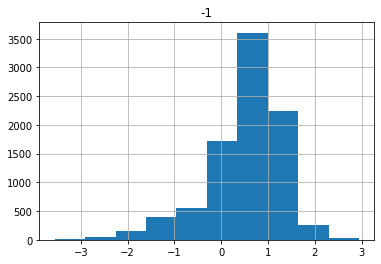

In [100]:
feature_df.hist()

## PL TCN Model

In [107]:
from model.pl_tcn import TCNModel

In [153]:
m_params = {
	'pad_type': 'same',    
	'num_blocks': 1,
	#'block_channels': [[80, 80, 80]],
	#'block_channels': [[70, 70, 70]],
	'block_channels': [[40, 40]],
	#'block_channels': [[80, 80, 80]],
	#'block_channels': [[80, 70, 60]],
	#'block_channels': [[70, 60, 50]],
	'block_act': 'relu',
	'out_act': 'relu',
	'block_init': 'xavier_uniform',
	'out_init': 'xavier_uniform',
	'kernel_sizes': [7],
	'dilation_index': 'global',
	'global_dropout': 0,
	'no_dropout': [0],
	'out_shape': len(chosen_l.columns)*len(chosen_l.index.levels[1]) # directions * slots per direction
}
t_params = {
	'window_size': 20,
	'flatten_features': False,
	'epochs': 200,#500,
	'batch_size': 64*2,
	'loss': 'ce',
	'opt': {
		'name': 'adam',
		'kwargs': {
			'lr': .001
		}
	},
	'sch': {
#		'name': 'rpl',
#		'kwargs': {
#			'mode': 'min',
#			'factor': 0.1,
#			'patience': 10,
#			'threshold': 0.0001,
#			'threshold_mode': 'rel',
#			'cooldown': 0,
#			'min_lr': 0
#		}
	}
}

In [154]:
mdl = TCNModel(m_params, t_params, (feature_df, label_df, target_df))

In [155]:
mdl

TCNModel(
  (loss): CrossEntropyLoss()
  (clf): OutputLinear(
    (emb): TemporalConvNet(
      (convnet): Sequential(
        (RB_0): ResidualBlock(
          (net): Sequential(
            (TL_0_0): TemporalLayer1d(
              (layer): Sequential(
                (0): Conv1d(4, 40, kernel_size=(7,), stride=(1,), padding=(3,))
                (1): ReLU()
                (2): Dropout(p=0, inplace=False)
              )
            )
            (TL_0_1): TemporalLayer1d(
              (layer): Sequential(
                (0): Conv1d(40, 40, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
                (1): ReLU()
                (2): Dropout(p=0, inplace=False)
              )
            )
          )
          (downsample): Conv1d(4, 40, kernel_size=(1,), stride=(1,))
          (out_act): ReLU()
        )
      )
    )
    (out): Linear(in_features=40, out_features=2, bias=True)
  )
)

In [156]:
# default logger used by trainer
logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    name='lightning_logs'
)
escb = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=60, verbose=False, mode='min')
trainer = pl.Trainer(amp_level='O1',
                     #precision=16,
                     gpus=1,
                     #benchmark=True,
                     #logger=logger,
                     #check_val_every_n_epoch=1,
                     max_epochs=t_params['epochs'],
                     #auto_lr_find=False,
                     #reload_dataloaders_every_epoch=True,
                     #track_grad_norm=2,
                     early_stop_callback=escb)
                     #log_save_interval=100)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [157]:
trainer.fit(mdl)

INFO:lightning:
   | Name                                    | Type             | Params
-------------------------------------------------------------------------
0  | loss                                    | CrossEntropyLoss | 0     
1  | clf                                     | OutputLinear     | 12 K  
2  | clf.emb                                 | TemporalConvNet  | 12 K  
3  | clf.emb.convnet                         | Sequential       | 12 K  
4  | clf.emb.convnet.RB_0                    | ResidualBlock    | 12 K  
5  | clf.emb.convnet.RB_0.net                | Sequential       | 12 K  
6  | clf.emb.convnet.RB_0.net.TL_0_0         | TemporalLayer1d  | 1 K   
7  | clf.emb.convnet.RB_0.net.TL_0_0.layer   | Sequential       | 1 K   
8  | clf.emb.convnet.RB_0.net.TL_0_0.layer.0 | Conv1d           | 1 K   
9  | clf.emb.convnet.RB_0.net.TL_0_0.layer.1 | ReLU             | 0     
10 | clf.emb.convnet.RB_0.net.TL_0_0.layer.2 | Dropout          | 0     
11 | clf.emb.convnet.RB_0.net.TL_0

1

In [211]:
for i in range(5):
    mdl = TCNModel(m_params, t_params, (feature_df, label_df, target_df))
    trainer = pl.Trainer(max_nb_epochs=t_params['epochs'], gpus=1, amp_level='O1', use_amp=True)
    trainer.fit(mdl)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


KeyboardInterrupt: 

## Debug Data (Runtime Transforms)

### Split into Train/Val/Test and Convert to Numpy Tensor

In [21]:
train_np, val_np, test_np = zip(*map(pd_to_np_tvt, (feature_df, label_df, target_df)))
shapes = np.asarray(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np))))
assert all(np.array_equal(a[:, 1:], b[:, 1:]) for a, b in pairwise(shapes)), 'feature, label, target shapes must be identical across splits'
assert all(len(np.unique(mat.T[0, :]))==1 for mat in shapes), 'first dimension (N) must be identical length in each split for all (feature, label, and target) tensors'

### Runtime Preproc

In [22]:
params = {
    'loss': 'ce',
    'batch_size': 256,
    'window_size': 20,
}

In [23]:
from model.train_util import batchify
def __preproc__(data, m_params, overlap=True):
    x, y, z = temporal_preproc_3d(data, window_size=m_params['window_size'], apply_idx=[0]) if (overlap) else stride_preproc_3d(data, window_size=m_params['window_size'])
    if (m_params['loss'] in ('bce', 'bcel', 'ce', 'nll')):
        y_new = np.sum(y, axis=(1, 2), keepdims=False)		# Sum label matrices to scalar values
        if (y.shape[1] > 1):
            y_new += y.shape[1]								# Shift to range [0, C-1]
        if (m_params['loss'] in ('bce', 'bcel')):
            y_new = np.expand_dims(y_new, axis=-1)
        y = y_new
    return (x, y, z)

def train_dataloader(t_params, flt):
    logging.info('train_dataloader called')
    return batchify(t_params, __preproc__(flt, t_params, overlap=True), shuffle=False)

def val_dataloader(t_params, flt):
    logging.info('val_dataloader called')
    return batchify(t_params, __preproc__(flt, t_params, overlap=True), shuffle=False)

def test_dataloader(t_params, flt):
    logging.info('test_dataloader called')
    return batchify(t_params, __preproc__(flt, t_params, overlap=True), shuffle=False)

### Overlapping Episodes:

In [24]:
train_ol_np = __preproc__(train_np, params)
val_ol_np = __preproc__(val_np, params)
test_ol_np = __preproc__(test_np, params)
print(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np)))[0])
print(tuple(map(np.shape, train_ol_np)))
print(np_value_counts(train_ol_np[1]))

((1359, 4, 1), (1359, 1, 2), (1359, 1, 2))
((1340, 4, 20), (1340,), (1340, 1, 2))
(array([0., 1.]), array([593, 747]))


### Non-Overlapping Episodes:

In [25]:
train_nol_np = __preproc__(train_np, params, False)
val_nol_np = __preproc__(val_np, params, False)
test_nol_np = __preproc__(test_np, params, False)
print(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np)))[0])
print(tuple(map(np.shape, train_nol_np)))

((1359, 4, 1), (1359, 1, 2), (1359, 1, 2))
((67, 4, 20, 1), (67, 2), (67, 1, 20, 2))


In [26]:
train_dl = train_dataloader(params, train_np)

INFO:root:train_dataloader called


In [34]:
for x, y, z in train_dl:
    print(x.shape)
    print(y.shape)
    print(z.shape)
    print(z)
    break

torch.Size([256, 4, 20])
torch.Size([256])
torch.Size([256, 1, 2])
tensor([[[ 0.0000e+00,  2.8551e-03]],

        [[ 0.0000e+00,  1.5526e-02]],

        [[-6.6128e-03,  0.0000e+00]],

        [[ 0.0000e+00,  1.6952e-02]],

        [[ 0.0000e+00,  2.6605e-02]],

        [[ 0.0000e+00,  1.9004e-03]],

        [[-4.5808e-02,  0.0000e+00]],

        [[ 0.0000e+00,  7.6504e-03]],

        [[ 0.0000e+00,  6.3621e-03]],

        [[-8.5257e-03,  0.0000e+00]],

        [[-3.5963e-02,  0.0000e+00]],

        [[-3.3373e-03,  0.0000e+00]],

        [[-1.1385e-02,  0.0000e+00]],

        [[-7.5013e-03,  0.0000e+00]],

        [[-3.8694e-02,  0.0000e+00]],

        [[ 0.0000e+00,  3.8204e-02]],

        [[-7.4484e-03,  0.0000e+00]],

        [[-1.6885e-02,  0.0000e+00]],

        [[-1.9789e-02,  0.0000e+00]],

        [[-3.9407e-02,  0.0000e+00]],

        [[-1.1513e-02,  0.0000e+00]],

        [[ 0.0000e+00,  2.0427e-02]],

        [[-3.6314e-02,  0.0000e+00]],

        [[-9.6486e-04,  0.0000e+00]]

## Sklearn Tests

In [31]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier

In [32]:
x_train, y_train, z_train = train_ol_np
x_val, y_val, z_val = val_ol_np
x_test, y_test, z_test = test_ol_np

In [33]:
def np_collapse_last_two_dim(arr):
    return arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2])

In [34]:
x_train.reshape(1340, 800)

ValueError: cannot reshape array of size 107200 into shape (1340,800)

In [35]:
x_train_new = np_collapse_last_two_dim(x_train)
x_val_new = np_collapse_last_two_dim(x_val)
x_test_new = np_collapse_last_two_dim(x_test)

In [36]:
# Logistic Regression
clf = LogisticRegression(C=10**-2, l1_ratio=.9, penalty='elasticnet', random_state=0, solver='saga').fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5092165898617511
diff : 0.000000%


In [37]:
# SGDClassifier
clf = SGDClassifier(alpha=10**-2, l1_ratio=.8, loss='log', penalty='elasticnet', random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5092165898617511
diff : 0.000000%


In [38]:
# SGDClassifier
clf = SGDClassifier(alpha=10**-5, l1_ratio=.1, loss='modified_huber', max_iter=1000, penalty='elasticnet', random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.49078341013824883
diff : -1.843318%


In [39]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=True, max_depth=4, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5
diff : -0.921659%


In [40]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', bootstrap=True, max_depth=None,
                             min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.511520737327189
diff : 0.230415%


In [41]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=7, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=True, max_depth=3, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5046082949308756
diff : -0.460829%


In [42]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=True, max_depth=4, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4700460829493088
diff : -3.917051%


In [43]:
# GradientBoostingClassifier
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                 criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4792626728110599
diff : -2.995392%


In [44]:
# GradientBoostingClassifier
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                 criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4815668202764977
diff : -2.764977%


In [45]:
# HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(loss='auto', learning_rate=0.1, max_iter=100, max_leaf_nodes=31,
                                     max_depth=4, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.49078341013824883
diff : -1.843318%


In [46]:
# RF Alt 1
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features='auto', class_weight='balanced')
clf = BaggingClassifier(base_estimator=clf1, bootstrap=True, bootstrap_features=False, n_estimators=100, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.46774193548387094
diff : -4.147465%


In [47]:
# RF Alt 2
clf = RandomForestClassifier(n_estimators=1, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=False, max_depth=3, min_impurity_decrease=0, random_state=0)
clf = BaggingClassifier(base_estimator=clf1, bootstrap=True, bootstrap_features=False, n_estimators=1000, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.46543778801843316
diff : -4.377880%


In [48]:
random_states = range(10)
results = np.zeros(len(random_states))
y_mean = y_val.mean()
for r in random_states:
        # RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, class_weight=None, criterion='entropy',
                                 bootstrap=True, max_depth=None, min_impurity_decrease=0, random_state=r).fit(x_train_new, y_train)
    sc = clf.score(x_val_new, y_val)
    diff = sc-y_mean
    results[r] = diff*100
    #print('base :', y_val.mean())
    #print('score:', sc)
    #print('diff : {:%}'.format((sc-y_val.mean())))
print(results)
print(results.mean())

KeyboardInterrupt: 

In [67]:
# Few Shot Tests
# XXX - Need to update for code changes
tr_split = .75
w = params['window_size']
tr, ts = int(tr_split*w), (1-tr_split)*w
print(tr, ts)

scs = []
for x, y, z in zip(*train_nol_np):
    x, y = x.T, y
    print(x.shape)
    print(x[0:tr].shape)
    print(x[tr:].shape)
    break
    clf = LogisticRegression(C=10**-2, l1_ratio=.9, penalty='elasticnet', random_state=0, solver='saga').fit(x[0:tr], y[0:tr].squeeze())
    #clf = LinearRegression().fit(x[0:tr], y[0:tr].squeeze())
    #yh = clf.predict(x[tr:])
    #|yp = clf.predict_proba(x[tr:])
    sc = clf.score(x[tr:], y[tr:].squeeze())
    scs.append(sc)
    #print(sc)
    #print(x)
    #print(y.squeeze())
    #print(z.T)

15 5.0
(160, 5)
(15, 5)
(145, 5)


In [68]:
(np.array(scs).mean()-train_nol[1].squeeze().mean())*100

/home/kev/crunch/model/nb-model_xg-model-data-fi.ipynb:1: RuntimeWarning: Mean of empty slice.
  {
/home/kev/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'train_nol' is not defined